# Factor NaN Report

Visualize NaN rates in factor parquet files.

In [13]:
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Optional: set repo root manually if auto-detect fails
# Example: repo_root = Path('C:/Users/BaiYang/CBOND_DAY')
repo_root = None

root = Path.cwd()
if repo_root is None:
    while root != root.parent and not (root / 'cbond_daily').exists():
        root = root.parent
    if not (root / 'cbond_daily').exists():
        raise FileNotFoundError('Cannot find repo root containing cbond_daily. Set repo_root explicitly.')
else:
    root = repo_root

# Load paths_config.json5 (minimal parsing)
paths_cfg = root / 'cbond_daily' / 'config' / 'paths_config.json5'
text = paths_cfg.read_text(encoding='utf-8')

# Extract dws_root value from JSON5-like config
m = re.search(r'dws_root\s*:\s*"([^"]+)"', text)
if not m:
    raise ValueError('Cannot parse dws_root from paths_config.json5')

factor_root = Path(m.group(1))
print('factor_root:', factor_root)


factor_root: D:\cbond_daily\factor_data


In [14]:
# Scan factor parquet files
files = sorted(factor_root.rglob('*.parquet'))
print('parquet files:', len(files))

# Optionally limit to recent files
recent_n = 30
files_recent = files[-recent_n:] if len(files) > recent_n else files
print('recent files:', len(files_recent))

# Collect NaN rates per file
rows = []
for f in files_recent:
    df = pd.read_parquet(f)
    # identify factor columns
    factor_cols = [c for c in df.columns if c not in ('trade_date','code','instrument_code','exchange_code')]
    if not factor_cols:
        continue
    nan_rate = df[factor_cols].isna().mean()
    trade_date = f.stem  # yyyymmdd
    rows.append(pd.DataFrame({'factor': nan_rate.index, 'nan_rate': nan_rate.values, 'trade_date': trade_date}))

if not rows:
    raise SystemExit('No factor columns found')

nan_df = pd.concat(rows, ignore_index=True)
print('rows:', len(nan_df))


parquet files: 492
recent files: 30
rows: 360


In [15]:
# Overall NaN rate by factor (average)
summary = nan_df.groupby('factor', as_index=False)['nan_rate'].mean().sort_values('nan_rate', ascending=False)
summary.head(20)


,factor,nan_rate
11,trend_prem_lag_simple_0.5_20_5_,0.908751
6,rolling_max_drawdown_28_,0.409369
9,rolling_ret_vol_28_,0.409369
5,rolling_max_drawdown_14_,0.406005
8,rolling_ret_vol_14_,0.406005
1,expr_alpha_001_9_60_15_8_6_20_,0.404967
10,rolling_ret_vol_7_,0.403829
7,rolling_max_drawdown_7_,0.403829
3,liquidity_,0.401905
2,intraday_momentum_,0.401905


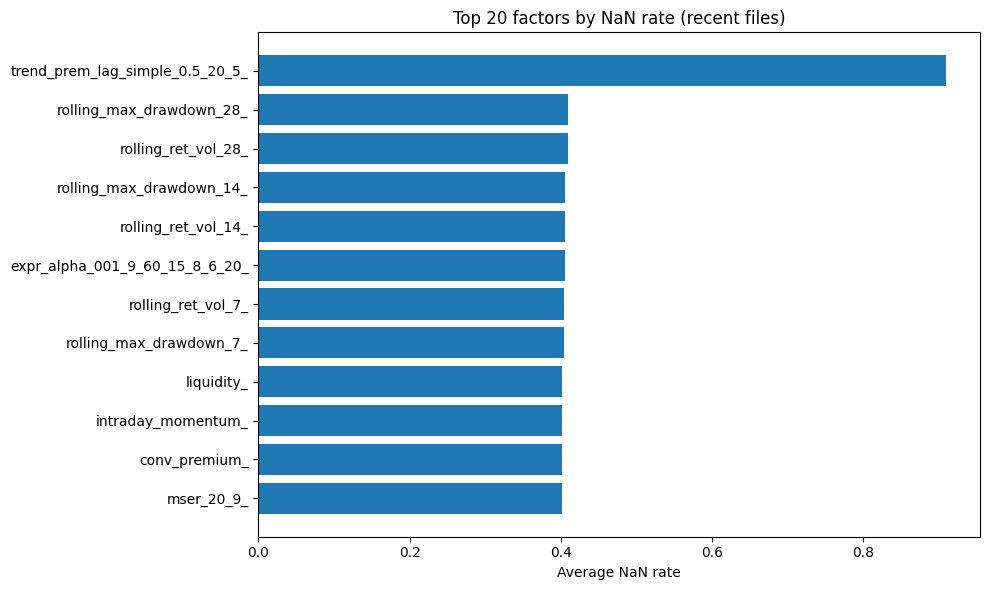

In [16]:
# Plot top 20 factors by NaN rate
plt.figure(figsize=(10, 6))
head = summary.head(20)
plt.barh(head['factor'][::-1], head['nan_rate'][::-1])
plt.xlabel('Average NaN rate')
plt.title('Top 20 factors by NaN rate (recent files)')
plt.tight_layout()
plt.show()


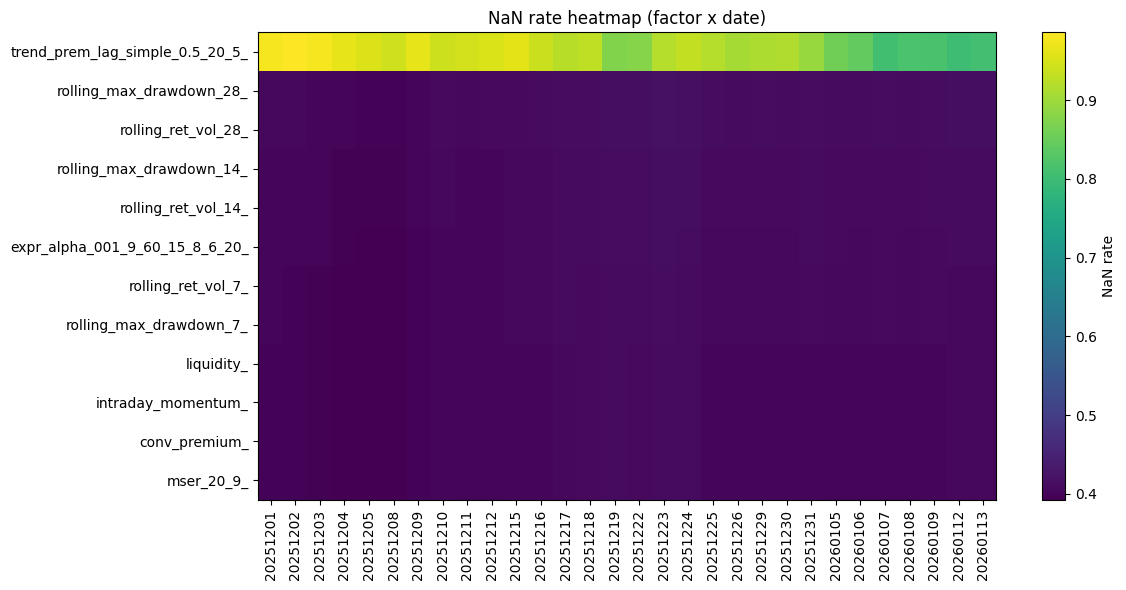

In [17]:
# Heatmap: factors vs dates (NaN rate)
# pivot to matrix
pivot = nan_df.pivot_table(index='factor', columns='trade_date', values='nan_rate')
# show only factors with any NaN
pivot = pivot.loc[pivot.mean(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(12, max(6, 0.3 * len(pivot))))
plt.imshow(pivot.values, aspect='auto', interpolation='nearest')
plt.colorbar(label='NaN rate')
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.title('NaN rate heatmap (factor x date)')
plt.tight_layout()
plt.show()


## View Factors on a Specific Date

In [18]:
# View factor values for a specific date
# date format: YYYYMMDD
view_date = '20260112'

# find parquet for that date
parquet_path = None
for p in factor_root.rglob(f"{view_date}.parquet"):
    parquet_path = p
    break

if parquet_path is None:
    raise FileNotFoundError(f'No parquet found for {view_date} under {factor_root}')

print('using', parquet_path)
df = pd.read_parquet(parquet_path)

# show a few rows and all factor columns
id_cols = ['trade_date', 'code', 'instrument_code', 'exchange_code']
existing_id_cols = [c for c in id_cols if c in df.columns]
factor_cols = [c for c in df.columns if c not in id_cols]

print('id columns:', existing_id_cols)
print('factor columns:', len(factor_cols))

display(df[existing_id_cols + factor_cols].head())
df

using D:\cbond_daily\factor_data\2026-01\20260112.parquet
id columns: ['trade_date', 'code']
factor columns: 12


,trade_date,code,conv_premium_,expr_alpha_001_9_60_15_8_6_20_,intraday_momentum_,liquidity_,mser_20_9_,rolling_max_drawdown_14_,rolling_max_drawdown_28_,rolling_max_drawdown_7_,rolling_ret_vol_14_,rolling_ret_vol_28_,rolling_ret_vol_7_,trend_prem_lag_simple_0.5_20_5_
0,2026-01-12,110067.SH,8.447349,-0.001187,0.021754,3.276472e+08,0.500879,-0.144441,-0.154753,-0.120568,0.025924,0.021663,0.035635,0.311254
1,2026-01-12,110070.SH,16.388142,-0.000756,0.014334,2.948131e+07,0.500218,-0.129298,-0.144928,-0.120418,0.008810,0.010612,0.009170,NaN
2,2026-01-12,110073.SH,38.320180,-0.000583,0.011951,3.293577e+08,0.499969,-0.147052,-0.147052,-0.147052,0.008183,0.007842,0.008694,0.147918
3,2026-01-12,110074.SH,6.837645,-0.002053,0.023620,1.030484e+09,0.503142,-0.156937,-0.197861,-0.074198,0.030612,0.039395,0.018736,2.483844
4,2026-01-12,110075.SH,6.917174,-0.000126,0.003012,2.685588e+08,0.500466,-0.030507,-0.069130,-0.018202,0.007216,0.009258,0.007088,0.183334


,trade_date,code,conv_premium_,expr_alpha_001_9_60_15_8_6_20_,intraday_momentum_,liquidity_,mser_20_9_,rolling_max_drawdown_14_,rolling_max_drawdown_28_,rolling_max_drawdown_7_,rolling_ret_vol_14_,rolling_ret_vol_28_,rolling_ret_vol_7_,trend_prem_lag_simple_0.5_20_5_
0,2026-01-12,110067.SH,8.447349,-0.001187,0.021754,3.276472e+08,0.500879,-0.144441,-0.154753,-0.120568,0.025924,0.021663,0.035635,0.311254
1,2026-01-12,110070.SH,16.388142,-0.000756,0.014334,2.948131e+07,0.500218,-0.129298,-0.144928,-0.120418,0.008810,0.010612,0.009170,NaN
2,2026-01-12,110073.SH,38.320180,-0.000583,0.011951,3.293577e+08,0.499969,-0.147052,-0.147052,-0.147052,0.008183,0.007842,0.008694,0.147918
3,2026-01-12,110074.SH,6.837645,-0.002053,0.023620,1.030484e+09,0.503142,-0.156937,-0.197861,-0.074198,0.030612,0.039395,0.018736,2.483844
4,2026-01-12,110075.SH,6.917174,-0.000126,0.003012,2.685588e+08,0.500466,-0.030507,-0.069130,-0.018202,0.007216,0.009258,0.007088,0.183334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,2026-01-12,128136.SZ,38.314932,-0.000360,0.005003,1.647945e+08,0.500154,-0.075652,-0.080506,-0.075652,0.014032,0.011976,0.015951,NaN
634,2026-01-12,128137.SZ,21.375763,-0.001108,0.024250,7.705912e+07,0.500389,-0.062955,-0.065438,-0.062955,0.011232,0.011268,0.012483,NaN
635,2026-01-12,128138.SZ,65.969053,-0.000196,0.005056,3.735386e+07,0.500084,-0.026848,-0.026848,-0.021409,0.002581,0.002226,0.002075,NaN
636,2026-01-12,128141.SZ,15.648494,-0.000216,0.006379,4.280865e+07,0.500193,-0.067035,-0.072681,-0.066891,0.005749,0.005296,0.005485,0.005531
